## Regressão simbólica aplicada ao modelo populacional de Gompertz

<p style='text-align: justify'> Nesse Notebook, estamos trabalhando a aplicação da regressão simbólica no modelo populacional de Gompertz, o qual buscamos fazer uma otimização para aproximar soluções de expressões matemáticas de equações diferenciais. Usamos, para isso, a construção de um algoritmo evolutivo. </p>

<p style='text-align: justify'> Para iniciar o nosso processo de regressão, precisamos importar o módulo DEAP do Python, onde temos armanezadas todas as funções e operadores necessários para criar o algoritmo. Além disso, importamos as bibliotecas numpy, sympy, operator. </p>

In [1]:
# Import de bibliotecas 

from deap import base, creator, tools, gp
from deap.algorithms import eaSimple
import math
import numpy
import operator
import random as rd
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
plt.style.use('seaborn-bright')
from sympy import Symbol, expand
from funcoes import gompertz, runge_kutta
from funcoes import Div, Exp

### Solução numérica para o modelo dada pelo método de Runge-Kutta

<p style='text-align: justify'> Defnindo os valores de constantes do método de Runge-Kutta, uma vez que queremos comparar o indivíduo gerado pela regressão com a solução numérica definida pelo método de aproximação de Runge-Kutta, o qual é ótimo para aproximar funções. Essa abordagem foi escolhida para uma generalização onde não conhecemos a solução real da EDO, tratando a aproximação por Runge-Kutta como a solução analítica. Importante ressaltar que os valores de 'X0' e 'K' foram os parâmetros que retornaram as melhores aproximações. </p>

In [2]:
T0 = 0  # Tempo inicial
TF = 1  # Tempo final
H = 0.01  # Passo
X0 = 3  # Valor inicial
K = 1  # Constante da equação diferencial

T, X = runge_kutta(gompertz, T0, X0, TF, H, K)  # Computando o função de Runge-Kutta

### Algoritmo genético de Regressão simbólica 

Vamos, então, definir as constantes do nosso problema, as quais dizem respeito a quantidade de gerações que queremos otimizar e o tamanho de cada uma.

In [3]:
# CONSTANTES RELACIONADAS A BUSCA

NUM_GERACOES = 500   # Número de gerações
TAMANHO_POP = 1000   # Tamanho da população
TAMANHO_TORNEIO = 3   # Quantidade de indivíduos que duelam a cada torneio
CHANCE_CRUZAMENTO = 0.5   # Chance de ocorrer cruzamento entre indivíduos
CHANCE_MUTACAO = 0.03   # Chance de ocorrer mutação em um indivíduo

<p style='text-align: justify'> Inicializando a montagem do nosso algoritmo, precisamos definir quais são os genes possíveis para cada indivíduo. Usamos, assim, o PrimitiveSet do DEAP para realizar essa tarefa. </p>

In [4]:
# Definindo os genes pelo PrimitiveSet
pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(Div, 2)
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(Exp, 1)

#pset.addPrimitive(np.cos, 1); serve apenas para funções trigonométricas
#pset.addPrimitive(np.sin, 1); serve apenas para funções trigonométricas

# Adicionando uma constante efêmera no PrimitiveSet de genes, importante para garantir que hajam constantes com valores numéricos
pset.addEphemeralConstant("rand105", lambda: rd.randint(-1,1))

# Renomendo o argumento para a expressão ficar em função de 't'
pset.renameArguments(ARG0='t')

<p style='text-align: justify'> Agora podemos criar uma classe para o cálculo do fitness de acordo com os parâmetros exigidos pelo nosso algoritmo, bem como criar uma classe de indivíduo que será criado baseado na sua profundidade máxima do modelo de árvore primitiva do DEAP. </p>

In [5]:
# Convocando a função de fitness e declarando uma minimização
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

# Convocando a função que cria o indivíduo a partir do PrimitiveSet que representam os genes do indivíduo.
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)  

<p style='text-align: justify'> Além de podermos registrar as ferramentas que serão utilizadas para realizar as operações de algoritmos evolutivos. Ou seja, estamos definindo a forma como os individuos e a população serão gerados de acordo com as funções operadoras do DEAP. </p>

In [6]:
toolbox = base.Toolbox()  # Criando uma caixa de ferramentas
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)  # Gerando expressões para definir funções e terminais disponíveis
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)  # Registrando a função de criação do indivíduo
toolbox.register("population", tools.initRepeat, list, toolbox.individual)  # Registrando a função de criação da população
toolbox.register("compile", gp.compile, pset=pset)   # Registrando a função de campilação do indivíduo para torná-lo executável

<p styl='text-align: justify'> Para podermos comparar a regressão e o método de Runge-Kutta, precisamos definir uma função de fitness para calcular o RMSE entre elas. </p>

In [7]:
# Definindo nossa própria função de fitness para gerar o RMSE entre a regressão e a solução numérica (Runge-Kutta)
def fitness(individual, points):
    # solução numérica:
    # Transformar a expressão em função:
    func = toolbox.compile(expr=individual)
    Xexpr = func(T)
    RMSE = np.sqrt(sum((Xexpr - X)**2))
    tamanho = len(str(individual))
    if tamanho > 50:
        return float('inf'),
    else:
        return (RMSE**1) * (1+tamanho/5)**0,

<p styl='text-align: justify'>  </p>

In [8]:
toolbox.register("evaluate", fitness, points = list(np.arange(T0, TF + H, H)))  # Registrando uma função de fitness
toolbox.register("select", tools.selTournament, tournsize=TAMANHO_TORNEIO)   # Registrando o operador de seleção por torneio
toolbox.register("mate", gp.cxOnePoint)   # Registrando o operador de cruzamento
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)   # Registrando o operador de mutação da árvore para determinar sua profundidade
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)  # Registrando o operador de mutação
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))  # Registrando o tamanho limite do indivíduo gerado pelo cruzamento, dado pela quantidade de genes
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))  # Registrando o tamanho limite do indivíduo gerado pela mutação

<p style='text-align: justify'> Usando as classes Statistic e MultiStatistic do módulo tools do DEAP, para computar estatísticas e múltiplas estatísticas, respectivamente, em uma popoulação. Para isso, usamos uma função lambda que computa o fitness de cada indivíduo para registras as funções do numpy: average, standard deviation e minimum. </p>

In [9]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)  # Computando os valores de fitness de indivíduos
stats_size = tools.Statistics(len)  # Computa o comprimento de indivíduos em uma população
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)  # Computa as estatísticas de fitness e tamanho
mstats.register("avg", numpy.mean)   # Registrando a função de média na classe de múltiplas estatísticas
mstats.register("std", numpy.std)   # Registrando a função de desvio padrão na classe
mstats.register("min", numpy.min)   # Registrando a função de mínimo valor na classe

<p style='text-align: justify'> A seguir, trabalhamos o processo de criação de uma população de indivíduos que possui um tamanho definido anteriormente, os quais são selecionados os melhores pelo Hall da Fama, dado por uma função de registro dos melhores indivíduos encontrados. Isso é feito pela função eaSimple do DEAP, que evolui uma população aplicando os operadores genéticos para criar e selecionar os melhores indivíduos. 
Essa função recebe os seguintes argumentos:

<ul>
    <li>população</li>
    <li>a caixa de ferramentas</li>
    <li>as chances de mutação e cruzamento</li>
    <li>o número de gerações</li>
    <li>as estatísticas computadas</li>
    <li>o Hall da Fama</li>
    <li>e um comando de print para dar continuidade no loop</li>
</ul>
    
</p>

In [10]:
pop = toolbox.population(n=TAMANHO_POP)    # Cria uma população de tamanho "TAMAHO_POP"
hof = tools.HallOfFame(5)    # Cria um Hall da Fama para armazenar os melhores 5 indivíduos
pop, log = eaSimple(pop, toolbox,
                cxpb=CHANCE_CRUZAMENTO,mutpb=CHANCE_MUTACAO, 
                ngen=NUM_GERACOES , stats=mstats, halloffame=hof, verbose=True)   # Realizando a evolução da população

   	      	                      fitness                      	                  size                 
   	      	---------------------------------------------------	---------------------------------------
gen	nevals	avg        	gen	min    	nevals	std        	avg  	gen	min	nevals	std    
0  	1000  	5.37623e+40	0  	2.31984	1000  	1.20096e+42	3.874	0  	2  	1000  	1.64807
1  	515   	1.13104e+115	1  	2.31984	515   	3.57489e+116	3.574	1  	1  	515   	1.61447
2  	495   	13.9536     	2  	2.31984	495   	16.9424     	3.338	2  	1  	495   	1.52176
3  	524   	1.07525e+41 	3  	2.31984	524   	1.69671e+42 	3.269	3  	1  	524   	1.58324
4  	475   	8.0376e+40  	4  	2.31984	475   	1.46527e+42 	3.312	4  	1  	475   	1.47535
5  	527   	12.5886     	5  	2.31984	527   	21.1129     	3.585	5  	1  	527   	1.59147
6  	477   	2.68812e+40 	6  	2.31984	477   	8.49632e+41 	3.737	6  	1  	477   	1.43451
7  	529   	2.68812e+40 	7  	1.4593 	529   	8.49632e+41 	3.972	7  	1  	529   	1.37521
8  	546   	38342.8     	8  	1.459

c:\venv\ilumpy\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


9  	555   	inf         	9  	1.4593 	555   	nan         	4.272	9  	1  	555   	1.36089
10 	522   	inf         	10 	1.4593 	522   	nan         	4.365	10 	1  	522   	1.32807
11 	495   	1.07795e+41 	11 	1.4593 	495   	1.70099e+42 	4.385	11 	1  	495   	1.3307 
12 	544   	1.44295e+41 	12 	1.4593 	544   	1.92093e+42 	4.523	12 	1  	544   	1.33547
13 	537   	1.07525e+41 	13 	1.4593 	537   	1.69671e+42 	4.628	13 	1  	537   	1.31743
14 	526   	4.49774e+41 	14 	1.4593 	526   	3.91244e+42 	4.64 	14 	1  	526   	1.32755
15 	552   	1.6102e+41  	15 	1.4593 	552   	2.07252e+42 	4.804	15 	1  	552   	1.48175
16 	509   	4.03485e+41 	16 	1.4593 	509   	3.26965e+42 	5.006	16 	1  	509   	1.50863
17 	538   	inf         	17 	1.31541	538   	nan         	5.231	17 	1  	538   	1.62038
18 	536   	inf         	18 	1.31541	536   	nan         	5.373	18 	1  	536   	1.82753
19 	513   	inf         	19 	1.31541	513   	nan         	5.669	19 	1  	513   	1.98631


C:\JupyterLab\REDES NEURAIS\RNAG_Trabalho_Final\funcoes.py:92: RuntimeWarning: overflow encountered in exp
  result = np.exp(x)
C:\Users\SOPHIA~1\AppData\Local\Temp/ipykernel_16124/3511287051.py:7: RuntimeWarning: overflow encountered in square
  RMSE = np.sqrt(sum((Xexpr - X)**2))


20 	505   	inf         	20 	1.31541	505   	nan         	5.982	20 	1  	505   	2.29862
21 	525   	inf         	21 	1.31541	525   	nan         	6.512	21 	2  	525   	2.72027
22 	504   	inf         	22 	1.31541	504   	nan         	7.154	22 	1  	504   	3.05291
23 	529   	inf         	23 	1.31541	529   	nan         	7.814	23 	1  	529   	3.26732
24 	500   	inf         	24 	1.31541	500   	nan         	8.453	24 	1  	500   	3.53635
25 	481   	inf         	25 	1.31541	481   	nan         	8.994	25 	1  	481   	3.54005
26 	577   	inf         	26 	1.31541	577   	nan         	9.409	26 	1  	577   	3.79654
27 	533   	inf         	27 	1.31541	533   	nan         	9.446	27 	2  	533   	3.61733
28 	541   	inf         	28 	1.31541	541   	nan         	9.561	28 	1  	541   	3.72133
29 	504   	inf         	29 	1.31541	504   	nan         	9.177	29 	1  	504   	3.59551
30 	474   	inf         	30 	1.31541	474   	nan         	8.941	30 	2  	474   	3.33279
31 	539   	inf         	31 	1.31541	539   	nan         	8.453	31 

<p style='text-align: justify'> O valor do RMSE é retornado na sequência de loops gerada acima, podendo ser visto nos dados referentes ao fitness, mais especificamente, na coluna de nome "min", referente a minimização do fitness. </p>

<p styl='text-align: justify'> Assim, finalmente obtendo as expressões retornadas pelo algoritmo, criamos um for loop para printar os indivíduos que foram armazenados no Hall da Fama, em que o primeiro da lista é o melhor indivíduo encontrado. </p>

In [11]:
for i in hof.items:
    print(str(i))
    print()

Exp(Div(Exp(0), sub(t, Div(Exp(t), sub(-1, t)))))

Exp(Div(Div(1, sub(sub(t, -1), t)), add(t, 1)))

Exp(Div(Div(1, sub(sub(t, -1), t)), add(1, t)))

Exp(Div(Div(1, sub(add(1, t), t)), sub(t, -1)))

Exp(Div(Div(1, sub(sub(t, -1), t)), sub(t, -1)))



### Reportando o melhor individuo encontrado

<p style='text-align: justify'> Esse reporte foi feito para obtermos um resultado gráfico para que haja uma comparação clara entre os dois métodos. Portanto, estamos definindo o melhor indivíduo e plotando ele juntamento com a solução por Runge-Kutta. </p>

Exp(Div(Exp(0), sub(t, Div(Exp(t), sub(-1, t)))))


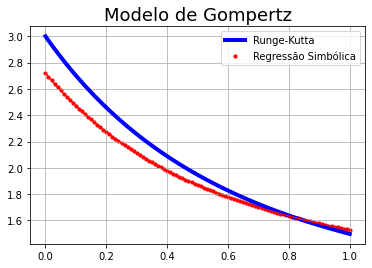

In [12]:
# Definindo o melhor indivíduo
melhor_individuo = str(hof.items[0])  # o melhor indivíduo é o primeiro apresentado na lista printada do Hall da Fama
#melhor_individuo_ever = 'X0_mul(Exp(K_mul(t)))'
print(melhor_individuo)
func = toolbox.compile(expr=melhor_individuo)  # Compilando esse indivíduo em um executável
Xexpr = func(T)
#func = toolbox.compile(expr=melhor_individuo_ever)
#Xbest = func(T)

# Plotando o gráfico
fig, ax = plt.subplots(1,1)
ax.set_title('Modelo de Gompertz', size = 18)
ax.plot(T, X, label = 'Runge-Kutta', c = 'b', linewidth = 4)
ax.scatter(T, Xexpr, label = 'Regressão Simbólica', c = 'r', s = 10)
ax.plot(T, Xexpr, c = 'r')
#ax.plot(T, Xbest, label = 'Analitica', c = '0')
ax.legend()

ax.legend()
ax.grid('--')
#plt.savefig('resultados\Resultado_Gompertz_1.png', dpi = 200)

<p style='text-align: justify'> Como obtivemos uma representação da expressão como uma string, ou seja, de maneira simbólica, queremos transformá-la em uma representação numérica. Fazemos isso usando o código a seguir. </p>

In [13]:
# Definindo as funções para computar a representação simbólico utilizando o sympy e transformar em funções numéricas
def Div(left, right):
    return left / right

def Exp(x):
    return sp.exp(x)

# Usando um novo PrimitiveSet para definir os operadores matemáticos
new_pset = gp.PrimitiveSet("MAIN", 1)

new_pset.addPrimitive(operator.add, 2)
new_pset.addPrimitive(operator.sub, 2)
new_pset.addPrimitive(operator.mul, 2)
new_pset.addPrimitive(Div, 2)
new_pset.addPrimitive(operator.neg, 1)
new_pset.addPrimitive(sp.cos, 1)
new_pset.addPrimitive(sp.sin, 1)
new_pset.addPrimitive(Exp, 1)

# Novamente adicionando a constante efêmera
new_pset.addEphemeralConstant("rand106", lambda: rd.randint(-1,1))

# Renomeando o argumento para que seja representado em função do tempo
new_pset.renameArguments(ARG0='t')

# Registrando a função de compilação do indivíduo numérico
toolbox.register("compile", gp.compile, pset=new_pset)

In [14]:
func = toolbox.compile(expr=melhor_individuo)  # Compilando o indivíduo em um executável

# Definindo os símbolos como terminais
t = Symbol('t')
X0 = Symbol('X_0')
K = Symbol('k')

<p style='text-align: justify'> Ao final, temos a nossa expressão simbólica que fita os dados </p>

In [15]:
print("O melhor individuo encontrado: ")
display(sp.expand(func(t)))

O melhor individuo encontrado: 


exp(1/(t - exp(t)/(-t - 1)))